# MNIST in PyTorch, demo

In [1]:
# !pip install ipywidgets==7.6. 0

In [2]:
import torch
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True
)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

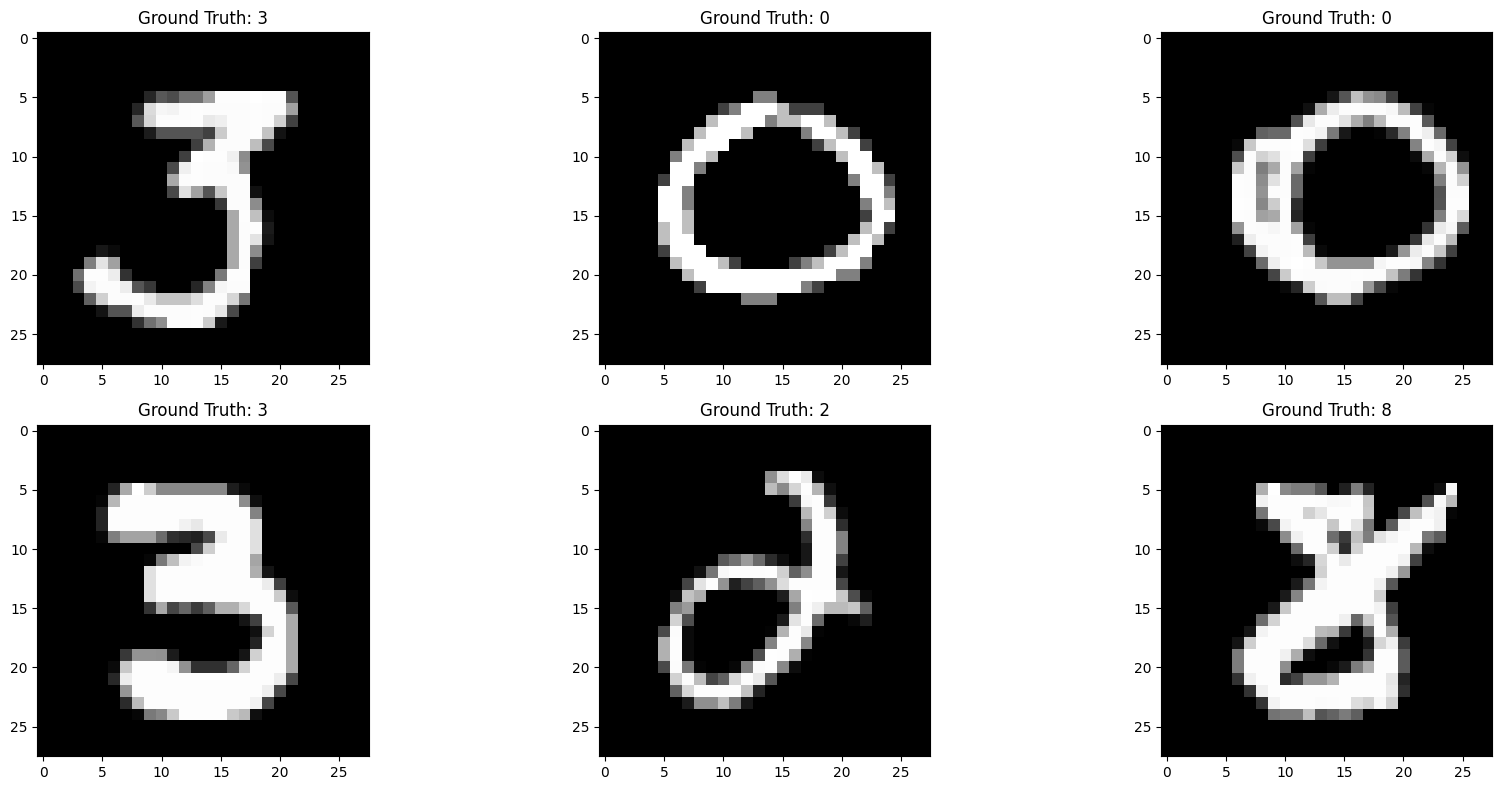

In [7]:
import matplotlib.pyplot as plt
import matplotlib

fig, gs = plt.figure(figsize=(18, 8)), matplotlib.gridspec.GridSpec(2, 3)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i, 0], cmap='gray', interpolation='none') # cmap='gray_r'
    plt.title("Ground Truth: {}".format(example_targets[i]))

<div class="alert alert-info">
<b>Question 2:</b> What are the numbers and what is their physical meaning?
</div>

In [10]:
example_data[0, 0, 20]

tensor([0.0000, 0.0000, 0.0000, 0.4471, 0.9922, 0.9922, 0.9294, 0.1961, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4706, 0.9922, 0.9922,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

### Linear classifier

Prediction $$ y_{pred} = x \cdot W + b $$

<div align="center">
    <img src="images/linear_classification_scheme.jpg" width=700/>
    $x\quad\quad\quad\cdot\quad W\quad\quad\quad+\quad b$
</div>


### Ten dividing planes

<div align="center">
    <img src="images/2D_example.jpg" width=800/>
</div>

 * In our example, the vector space is 784-dimensional ($\mathbb{R}^{784}$)

If $\text{y_true}_i \in \mathbb{R}$ (that is, a linear **regression** problem), then to minimize the sum of squares of differences (least squares), the answer is calculated **analytically** by the formula:
$$\hat{W} = (X^TX)^{-1}X^T\text{y_true}$$

In general case the optimization problem is solved **numerically** by minimizing the loss function. Most often by gradient descent.

<div align="center">
    <img src="images/momentum.jpg" width=900/>
</div>

[Distill.pub momentum](https://distill.pub/2017/momentum/)

### Softmax — is for classification

We translate our linear model answers (logits) into class probabilities:

$$ p(c=0| x) = \frac{e^{y_0}}{e^{y_0}+e^{y_1}+\dots+e^{y_n}} = \frac{e^{y_0}}{\sum\limits_i e^{y_i}} \\
   p(c=1| x) = \frac{e^{y_1}}{e^{y_0}+e^{y_1}+\dots+e^{y_n}} = \frac{e^{y_1}}{\sum\limits_i e^{y_i}} \\
   \dots
$$


### Maximum likelihood principle (reminder)

$\arg\max\limits_w {P(Y|w, X)P(w)} \color{red}{=} \arg\max\limits_w \prod\limits_{i=1}^\ell {P(y_i|w, x_i)P(w)} = \\ \arg\max\limits_w \sum\limits_{i=1}^\ell \log P(y_i|w, x_i) + \log P(w)$

$\ell$ — amount of objects in X

### Minimizing the Loss Function

$$L(w) = \sum\limits_{i=1}^\ell {\mathcal{L}(y_i, x_i, w)} = -\sum\limits_{i=1}^\ell \ln P(y_i|w, x_i) \to \min\limits_w$$

 * this is **cross-entropy loss** for $y_i \in \{0, 1\}$
 * cross-entropy loss: x_i, q_i — model probabilities for first class, p_i — ground truth of probabilites
 
   - $-\sum\limits_{i=1}^\ell p_i * ln (q_i)$
 * in our case

$$ L(W, b) = - \sum\limits_j \ln \frac{e^{(x_jW + b)_{y_j}}}{\sum\limits_i e^{(x_jW + b)_{i}}}$$

 * the minimum of the function is found by **stochastic gradient descent**

$$ W^{k+1} = W^{k} - \eta \frac{\partial L}{\partial W} \\
   b^{k+1} = b^{k} - \eta \frac{\partial L}{\partial b}$$



<div class="alert alert-info">
<b>Question 3:</b> Why is this loss function $L$ a cross-entropy loss?
</div>

### Learning with mini-batches

We reduce the variance of the gradient.

**Input**: sample $X^\ell$, learning rate $\eta$, forgetting rate $\lambda$

**Output**: weight vector $w \equiv (w_{jh}, w_{hm})$

1. initialize weights

2. initialize the evaluation of the functional

  $$Q = \frac{1}{\ell} \sum\limits_{i=1}^\ell \mathcal{L}_i (w)$$

3. **repeat**

   4. choose $M$ objects $x_i$ from $X^\ell$ randomly
   5. calculate loss: $\varepsilon = \frac{1}{M} \sum\limits_{i=1}^M \mathcal{L}_i (w)$
   6. make a gradient step: $\color{red}{w = w - \eta \frac{1}{M} \sum\limits_{i=1}^M \nabla \mathcal{L}_i (w)} $
   7. evaluate the functional: $Q = \lambda \varepsilon + (1 - \lambda) Q$

8. **until** the value of $Q$ and/or the weights of $w$ converge

### Single-layer neural network for classification

To build a neural network in Python, we will continue to work with the PyTorch library.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class FirstNN(nn.Module):
    def __init__(self):
        super(FirstNN, self).__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(784, 10) # W, b
        
    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        return F.log_softmax(x)

In [14]:
network = FirstNN()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [16]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target) # negative log likelihood loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset))
            )
#             torch.save(network.state_dict(), '/results/model.pth')
#             torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [17]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset))
    )

### Everything is ready — let's start training right now!

In [18]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/tmp/ipykernel_4390/1917719862.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/avalur/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3239, Accuracy: 947/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327024
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.234981
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.158717
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.071819
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.938018
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.890367
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.826004
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.803910
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.636716
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.670705
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.561340
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.455543
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.456102
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.431081
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.483948
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.260301
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.362908
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.255702
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.311701
Train Epoch: 1 [12160/6

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.501239
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.494235
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.633906
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.545160
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.540770
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.537130
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.702468
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.402732
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.516586
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.445262
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.465458
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.456300
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.568468
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.406091
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.627557
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.525497
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.487847
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.537736
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.358947
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.450794


Text(0, 0.5, 'negative log likelihood loss')

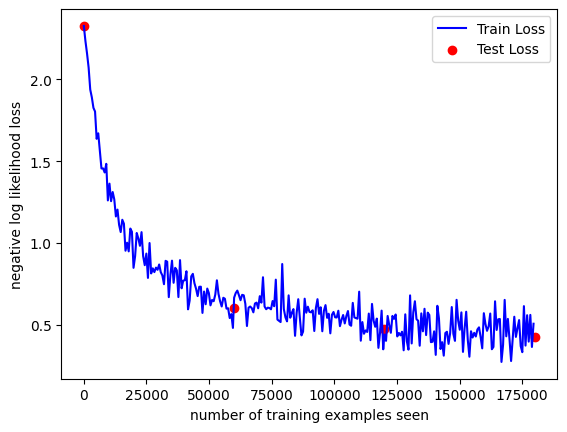

In [19]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

<div align="center">
    <img src="images/cat_a_break_mem.jpg" width=900/>
</div>

In [20]:
network

FirstNN(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [28]:
!pip install torchinfo

In [21]:
from torchinfo import summary

summary(network)

Layer (type:depth-idx)                   Param #
FirstNN                                  --
├─Flatten: 1-1                           --
├─Linear: 1-2                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

### Convolution network — next lecture

<div align="center">
    <img src="images/cnn_architecture.jpg" width=800 />
    <a href="https://www.pyimagesearch.com/wp-content/uploads/2014/06/cnn_architecture.jpg">
        Source</a> 
</div>